In [1]:
# Human-in-the-Loop Pattern with LangGraph
# 
# This notebook demonstrates how to implement human-in-the-loop approval for tool calls.
# 
# Key concepts:
# 1. Use interrupt_before=["node_name"] to pause execution before a specific node
# 2. Use MemorySaver checkpointer to persist state between interactions
# 3. Use stream() and get_state() to detect and handle interrupts
# 4. Resume execution by calling graph.stream(None, config) from the checkpoint
#
# Pattern:
# - chatbot makes tool calls → interrupt before approval_node → human approves/rejects → execute tools

from typing import Annotated
from typing_extensions import TypedDict
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [2]:
from dotenv import load_dotenv

load_dotenv()


True

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


In [4]:
@tool
def get_stock_price(symbol: str) -> float:
    """Fetch the current stock price for a given stock symbol.
    
    Args:
        symbol: The stock ticker symbol (e.g., 'MSFT', 'AAPL', 'GOOG', 'TSLA')
    
    Returns:
        The current price of the stock as a float
    """
    return {
        "MSFT": 234.56,
        "AAPL": 123.45,
        "GOOG": 2345.67,
        "TSLA": 789.01,
    }.get(symbol, 0.0)

@tool
def buy_stock(symbol: str, quantity: int) -> str:
    """Buy a specific quantity of a stock in a simulated way.
    
    Args:
        symbol: The stock ticker symbol (e.g., 'MSFT', 'AAPL', 'GOOG', 'TSLA')
        quantity: The number of shares to buy
    """
    return f"Successfully simulated purchase of {quantity} shares of {symbol}"

def approval_node(state: State):
    """Execute or cancel tool calls based on user decision"""
    # At this point, we've already been interrupted
    # The graph will provide the resume value
    return {}  # Just continue to tools

tools = [get_stock_price, buy_stock]

llm = init_chat_model(model="ollama:llama3.2:latest")
llm_with_tools = llm.bind_tools(tools)



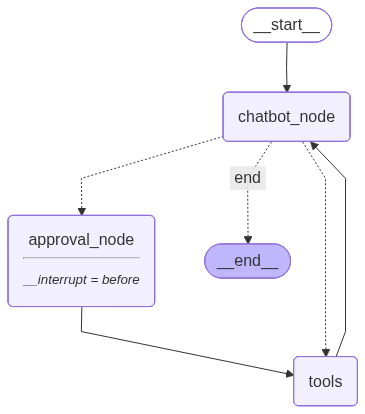

In [5]:
def route_after_chatbot(state: State):
    """Route to approval node only for buy_stock calls, otherwise to tools or end"""
    last_message = state["messages"][-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        # Check if any tool call is buy_stock (requires approval)
        for tool_call in last_message.tool_calls:
            if tool_call['name'] == 'buy_stock':
                return "approval_node"
        # Other tools don't need approval, go directly to tools
        return "tools"
    
    return "end"

def chatbot(state: State) -> State:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Setup memory checkpointer (REQUIRED for human-in-the-loop)
memory = MemorySaver()

# Build the graph
builder = StateGraph(State)
builder.add_node("chatbot_node", chatbot)
builder.add_node("approval_node", approval_node)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "chatbot_node")

# Conditional routing: buy_stock → approval, other tools → direct execution
builder.add_conditional_edges(
    "chatbot_node",
    route_after_chatbot,
    {
        "approval_node": "approval_node",
        "tools": "tools",
        "end": END
    }
)

# After approval, execute the tools
builder.add_edge("approval_node", "tools")

# After tools execute, loop back to chatbot for final response
builder.add_edge("tools", "chatbot_node")

# Compile with checkpointer and interrupt before approval node
graph = builder.compile(checkpointer=memory, interrupt_before=["approval_node"])

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
config = {"configurable": {"thread_id": "1"}}

# Initial request
user_input = {"messages": [{"role": "user", "content": "Buy 20 MSFT shares at the current price"}]}

# Stream the graph execution to see when it hits the interrupt
for event in graph.stream(user_input, config, stream_mode="updates"):
    if "__interrupt__" in event:
        print("⏸️  Execution paused for human approval")

# Check if we hit an interrupt
state = graph.get_state(config)
if state.next:
    print(f"\n🛑 Interrupt detected - waiting at: {state.next[0]}")
    
    # Extract tool call details from the last message
    last_message = state.values["messages"][-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            if tool_call['name'] == 'buy_stock':
                print(f"\n📋 Purchase Request:")
                print(f"   Symbol: {tool_call['args']['symbol']}")
                print(f"   Quantity: {tool_call['args']['quantity']}")
    
    # Get user decision
    decision = input("\n❓ Approve the purchase? (yes/no): ")
    
    if decision.lower() == "yes":
        print("\n✅ Resuming execution with approval...")
        
        # Continue from checkpoint
        for event in graph.stream(None, config, stream_mode="updates"):
            pass  # Let it execute
        
        # Get final result
        final_state = graph.get_state(config)
        print("\n📝 Final response:")
        for msg in final_state.values["messages"]:
            if hasattr(msg, 'content') and msg.content:
                print(f"  {msg.content}")
    else:
        print("\n❌ Purchase cancelled by user")
else:
    print("✅ Graph completed without interrupts")

⏸️  Execution paused for human approval

🛑 Interrupt detected - waiting at: approval_node

📋 Purchase Request:
   Symbol: MSFT
   Quantity: 20

✅ Resuming execution with approval...

📝 Final response:
  Buy 20 MSFT shares at the current price
  Successfully simulated purchase of 20 shares of MSFT
  Assuming an average price of $263.22 per share (current market price as of my knowledge cutoff in December 2023), the total cost would be:

20 shares x $263.22 per share = $5, quarter each buy 26,200


In [7]:
# Optional: Test a different query that doesn't require approval
from langchain_core.messages import HumanMessage

config_test = {"configurable": {"thread_id": "test_2"}}
test_input = {"messages": [HumanMessage(content="What is the current price of AAPL stock?")]}

print("Testing query that doesn't require approval...")
result = graph.invoke(test_input, config_test)
print(f"\nFinal answer: {result['messages'][-1].content}")


Testing query that doesn't require approval...

Final answer: The current price of AAPL stock is $123.45 per share.


In [8]:
# Note: You can use different LLM models by changing the model parameter:
# - ollama:llama3.1:8b (better tool calling than llama3.2)
# - gpt-4o-mini (requires OPENAI_API_KEY)
# - claude-3-5-sonnet-20241022 (requires ANTHROPIC_API_KEY)
# 
# Simply change Cell 3: llm = init_chat_model(model="your-model-here")
